In [1]:
import tensorflow as tf

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(0)

In [3]:
print(tf.__version__)

2.10.0


In [4]:
from keras.datasets import fashion_mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [5]:
from keras.optimizers import Adagrad

In [6]:
from keras.losses import SparseCategoricalCrossentropy

In [7]:
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
tf.keras.utils.set_random_seed(42)

In [11]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [12]:
print(train_images.shape, test_images.shape, train_labels.shape, test_labels.shape, sep='\n')

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [13]:
train_images = train_images / 255
test_images = test_images / 255

In [14]:
y_train_labels = to_categorical(train_labels)
y_test_labels = to_categorical(test_labels)

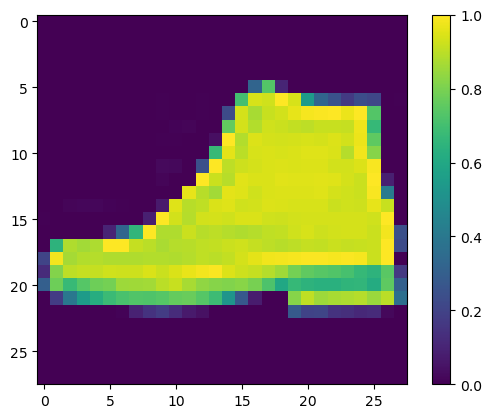

In [15]:
plt.figure()
plt.imshow(train_images[42])
plt.colorbar()
plt.show()

In [16]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [18]:
inputs = Input(shape=(28, 28))
x1 = Flatten()(inputs)
x = Dense(128, activation='relu')(x1)
outputs = Dense(10)(x)

model = Model(inputs, outputs)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.fit(train_images, y_train_labels, epochs=7, batch_size=1024, verbose=0)

In [22]:
test_loss, test_acc = model.evaluate(test_images, y_test_labels)
print(f'test loss: {test_loss:.3f}\ntest_acc {test_acc:.3f}')

313/313 [==============================] - 1s 3ms/step - loss: 0.4003 - accuracy: 0.8589
test loss: 0.400
test_acc 0.859


In [23]:
preds = model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [24]:
preds = np.argmax(preds, axis=1)

In [25]:
cm = confusion_matrix(test_labels, preds)

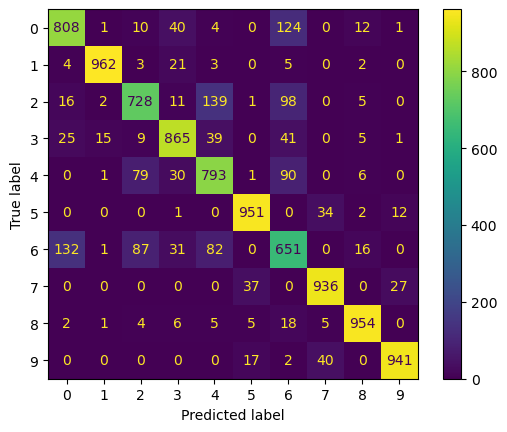

In [26]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [27]:
import tensorflow.nn as nn

In [33]:
level = 5
inputs = Input(shape=(28, 28), name='digits')
x = Flatten()(inputs)
for i in range(level):
    x = Dense(10*(10-i), name='dense_'+str(i))(x)
    x = nn.sigmoid(x)
x = Dense(10, name='predictions')(x)
outputs = nn.softmax(x)
model = Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = tf.keras.losses.MeanSquaredError()
batch_size = 1024

In [37]:
grad_log = []
epochs = 2
for epoch in range(epochs):
    for step, (x_batch_train, y_batch_train) in enumerate(zip(train_images, y_train_labels)):
        with tf.GradientTape() as tape:
            loggits = model(x_batch_train.reshape(1, 28, 28))
            y_batch_train = y_batch_train.reshape(1, 10)
            y_s = y_batch_train.shape
            y = tf.reshape(y_batch_train, shape=(y_s[0], 10, 1))
            l = tf.reshape(loggits, shape=(y_s[0], 10, 1))
            loss_value = loss_fn(y, l)
            grads = tape.gradient(loss_value, model.trainable_weights)
            g_g = []
            w_w = []
            for g_s in grads:
                if len(g_s.numpy().shape) == 1:
                    g_g.append(g_s.numpy()[0])
                if len(g_s.numpy().shape) == 2:
                    g_g.append(g_s.numpy()[0, 0])
                if len(g_s.numpy().shape) == 3:
                    g_g.append(g_s.numpy()[0, 0, 0])
                if len(g_s.numpy().shape) == 4:
                    g_g.append(g_s.numpy()[0, 0, 0, 0])
                    
            grad_log.append(g_g)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            #if step % 10000 == 0:
            #    print(f'Потери на обучении на шаге {step} составляют {float(loss_value)}')
             #   print(f'Уже увидели {(step + 1) * batch_size} примеров')
grad_log = np.array(grad_log)
                      

KeyboardInterrupt: 

In [ ]:
model.summary()

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Градиент по слоям')
plt.xlabel('Номер слоя')
plt.ylabel('Градиент')
plt.grid()
plt.plot(np.abs(grad_log[0, :]), '-ob', label='step 0')
plt.plot(np.abs(grad_log[10, :]), label='step 10')
plt.plot(np.abs(grad_log[100, :]), label='step 100')
plt.plot(np.abs(grad_log[1000, :]), label='step 1000')
plt.plot(np.abs(grad_log[10000, :]), label='step 1000')
plt.legend()
plt.show()

Ансамблевая модель

In [106]:
model1 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='selu'),
    Dense(10, activation='softmax')
])

model2 = Sequential()
model2.add(Flatten(input_shape=(28, 28)))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(10, activation='softmax'))

x_input = Input(shape=(28, 28))
x3 = Flatten()(x_input)
x3 = Dense(512, activation='tanh')(x3)
x_output = Dense(10, activation='softmax')(x3)
model3 = Model(x_input, x_output)

model1.compile(optimizer='adam',
               metrics=['accuracy'],
               loss=tf.keras.losses.SparseCategoricalCrossentropy())
               
model2.compile(optimizer='nadam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])
model3.compile(optimizer='adamax',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

hist1 = model1.fit(train_images, train_labels, epochs=10, batch_size=2048)
hist2 = model2.fit(train_images, train_labels, epochs=10, batch_size=2048)
hist3 = model3.fit(train_images, train_labels, epochs=10, batch_size=2048)

Epoch 1/10
30/30 [==============================] - 2s 48ms/step - loss: 0.9427 - accuracy: 0.6783
Epoch 2/10
30/30 [==============================] - 1s 45ms/step - loss: 0.5135 - accuracy: 0.8242
Epoch 3/10
30/30 [==============================] - 1s 46ms/step - loss: 0.4636 - accuracy: 0.8380
Epoch 4/10
30/30 [==============================] - 1s 46ms/step - loss: 0.4380 - accuracy: 0.8473
Epoch 5/10
30/30 [==============================] - 1s 45ms/step - loss: 0.4164 - accuracy: 0.8556
Epoch 6/10
30/30 [==============================] - 1s 48ms/step - loss: 0.4102 - accuracy: 0.8565
Epoch 7/10
30/30 [==============================] - 1s 46ms/step - loss: 0.4009 - accuracy: 0.8596
Epoch 8/10
30/30 [==============================] - 1s 45ms/step - loss: 0.3881 - accuracy: 0.8630
Epoch 9/10
30/30 [==============================] - 1s 44ms/step - loss: 0.3835 - accuracy: 0.8653
Epoch 10/10
30/30 [==============================] - 1s 47ms/step - loss: 0.3740 - accuracy: 0.8689
Epoch 1/1

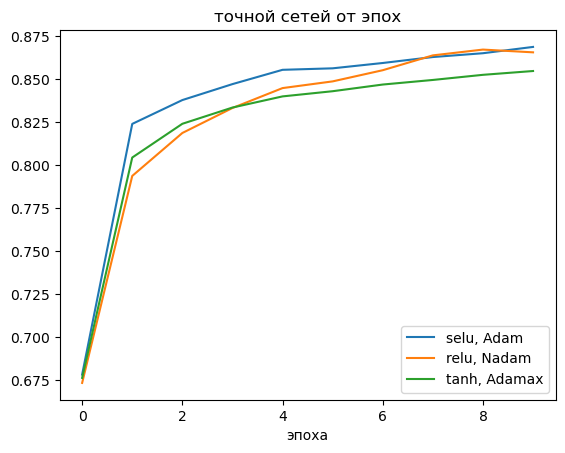

In [107]:
plt.plot(hist1.history['accuracy'], label='selu, Adam')
plt.plot(hist2.history['accuracy'], label='relu, Nadam')
plt.plot(hist3.history['accuracy'], label='tanh, Adamax')
plt.title('точной сетей от эпох')
plt.xlabel('эпоха')
plt.legend()
plt.show()

In [108]:
y_pred1 = np.argmax(model1.predict(test_images), axis=1)
y_pred2 = np.argmax(model2.predict(test_images), axis=1)
y_pred3 = np.argmax(model3.predict(test_images), axis=1)

cm1 = confusion_matrix(test_labels, y_pred1)
cm2 = confusion_matrix(test_labels, y_pred2)
cm3 = confusion_matrix(test_labels, y_pred3)

313/313 [==============================] - 3s 8ms/step


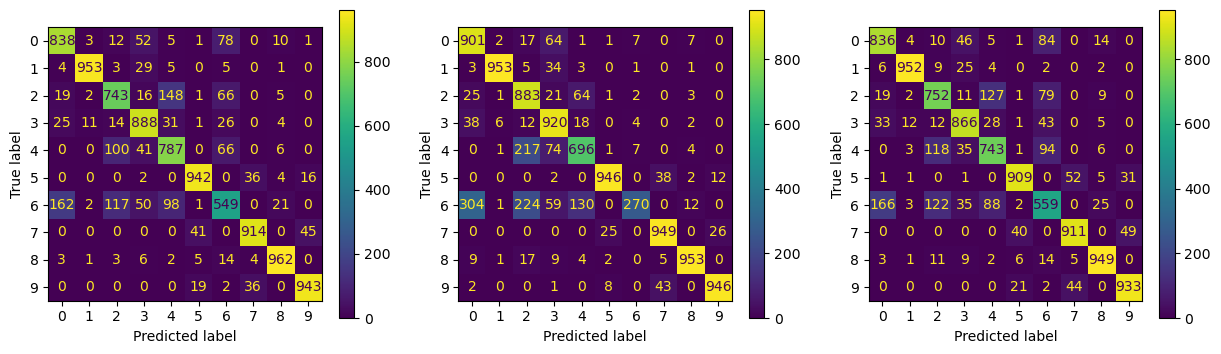

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(ax=ax1)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(ax=ax2)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)
disp3.plot(ax=ax3)
plt.show()

In [110]:
model1.save_weights('model1.h5')
model2.save_weights('model2.h5')
model3.save_weights('model3.h5')

In [111]:
input1 = Input(shape=(28, 28))
x1 = Flatten()(input1)
x1 = Dense(512, activation='selu')(x1)
x1 = Dense(10, activation='softmax')(x1)
model11 = Model(inputs=input1, outputs=x1)

x2 = Flatten()(input1)
x2 = Dense(512, activation='selu')(x2)
x2 = Dense(10, activation='softmax')(x2)
model22 = Model(inputs=input1, outputs=x2)

x3 = Flatten()(input1)
x3 = Dense(512, activation='selu')(x3)
x3 = Dense(10, activation='softmax')(x3)
model33 = Model(inputs=input1, outputs=x3)

out_all = tf.keras.layers.Average()([model11.output, model22.output, model33.output])
out_all = tf.keras.layers.Softmax()(out_all)

model_all = Model(inputs=input1, outputs=out_all)
model_all.compile(optimizer=Adagrad(learning_rate=0.01, epsilon=1e-8),
                 loss=SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

model11.load_weights('model1.h5')
model22.load_weights('model2.h5')
model33.load_weights('model3.h5')

In [112]:
model_all.summary()

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_44 (Flatten)           (None, 784)          0           ['input_16[0][0]']               
                                                                                                  
 flatten_45 (Flatten)           (None, 784)          0           ['input_16[0][0]']               
                                                                                                  
 flatten_46 (Flatten)           (None, 784)          0           ['input_16[0][0]']               
                                                                                           

In [113]:
from tensorflow.keras.utils import plot_model

In [114]:
plot_model(model_all, to_file='my_avg_ansmbl_model.png') #уже установил обе библиотеки, не пойму чего он хочет. Ядро перезапускал.

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [115]:
predictions_avg = model_all.predict(test_images)

313/313 [==============================] - 2s 5ms/step


In [116]:
predictions_avg = np.argmax(predictions_avg, axis=1)

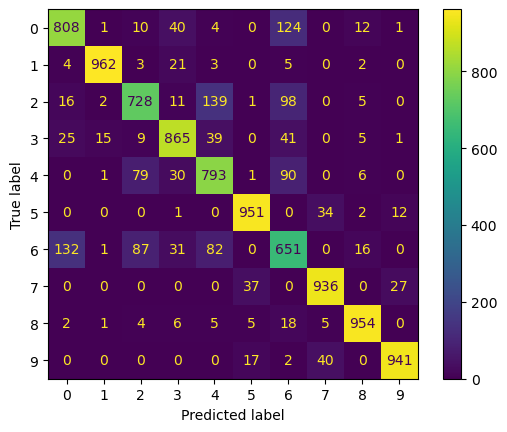

In [117]:
cm = confusion_matrix(test_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [118]:
model_all.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 1.6763 - accuracy: 0.8391


[1.6763240098953247, 0.8391000032424927]

Оптимайзеры и количество нейронов взял исходя из результатов предыдущей домашки. Пробовал много разных комбинаций, не стал здесь их все выкладывать, чтобы не захлямалять ноутбук. 